# Imports

In [0]:
%matplotlib inline
import argparse
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from torch.nn import functional as F
import matplotlib.pyplot as plt

# Datasets


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


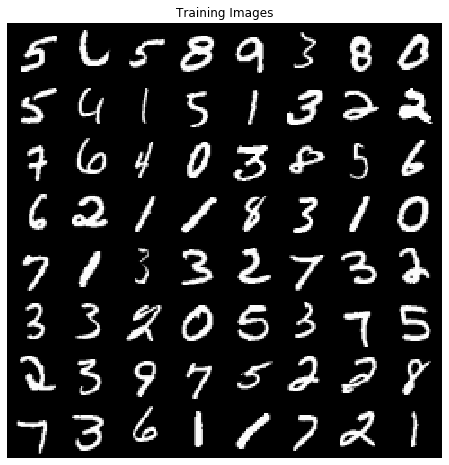

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
batch_size = 64
dataroot = 'mnist'
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = torchvision.datasets.MNIST(dataroot, 
                     train=True, 
                     download=True, 
                     transform=transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
seed=0
torch.manual_seed(seed)
np.random.seed(seed)
device=0
if device>=0 and torch.cuda.is_available():
  cudnn.benchmark = True
  torch.cuda.device(device)
  torch.cuda.manual_seed(seed)
else: 
  device=-1

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# VAE with only linear layers


In [0]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(encoder, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, output_size)
        self.fc22 = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x):
        x = x.view(-1, 784)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
      
class decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(decoder, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        ) 
    
    def forward(self, z):
        return self.main(z)

In [0]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VAE, self).__init__()
        self.encode = encoder(input_size, hidden_size, output_size)
        self.decode = decoder(input_size, hidden_size, output_size)    
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.encode.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
input_size, hidden_size, output_size = 784, 400, 20
lr = 1e-3
epochs = 50
model = VAE(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

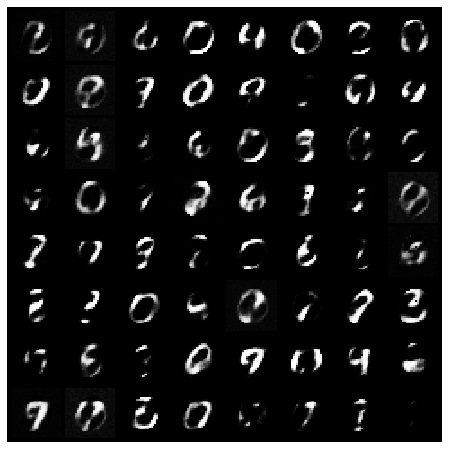

<Figure size 432x288 with 0 Axes>

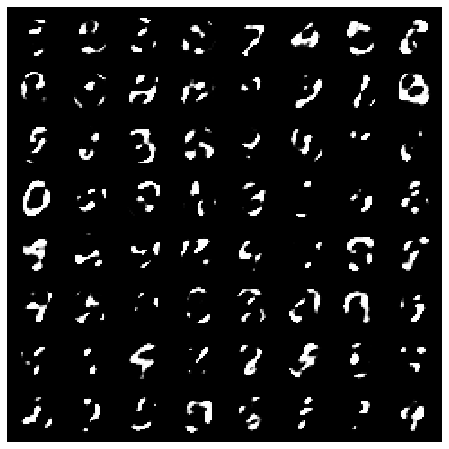

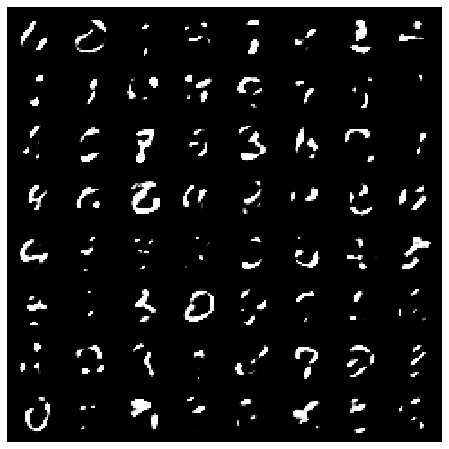

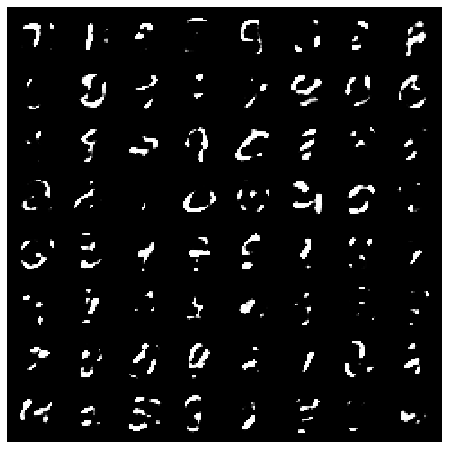

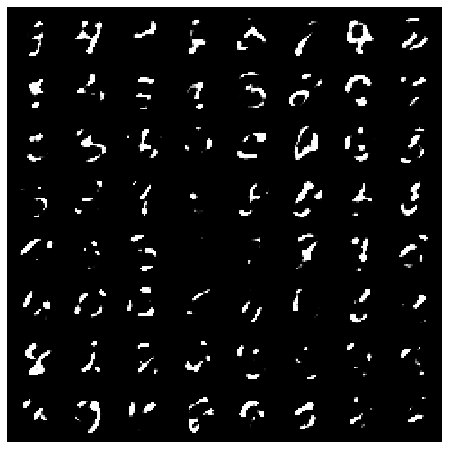

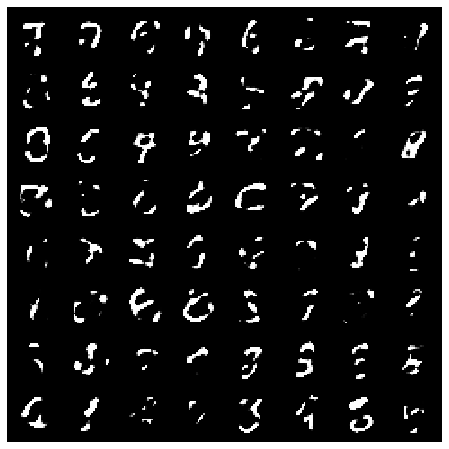

<Figure size 432x288 with 0 Axes>

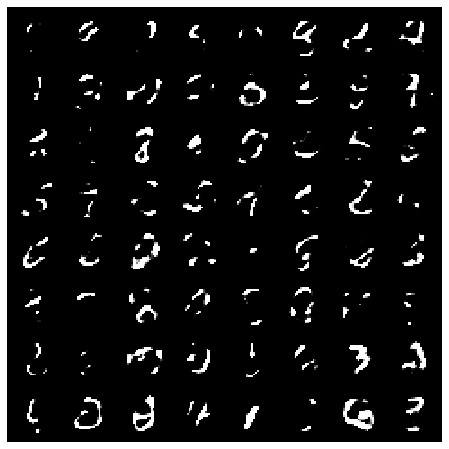

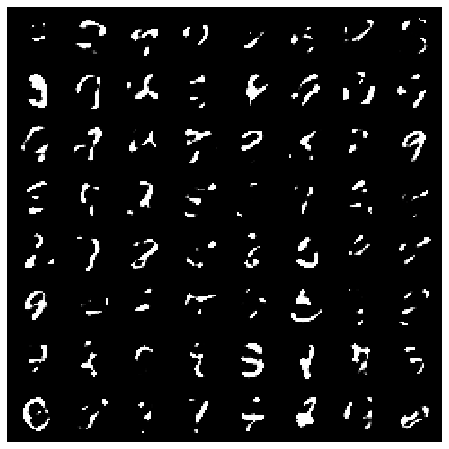

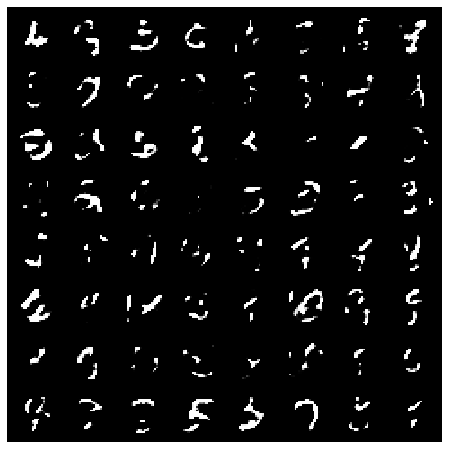

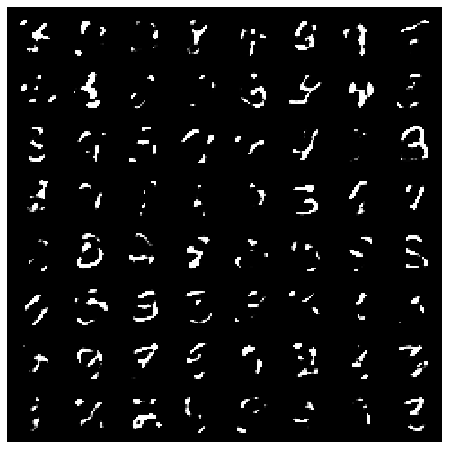

In [8]:
model.train()
losses = []
img_list = []
for i in range(epochs):
    loss_batches = []
    for data, target in dataloader:
        optimizer.zero_grad()
        image_gen, mu, logvar = model(data)
        loss_bce = F.binary_cross_entropy(image_gen, data.view(-1, 784), reduction='sum')
        loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_bce + loss_kl
        loss.backward()
        loss_batches.append(loss.item())
        optimizer.step()
    
    losses.append(np.mean(loss_batches))
    
    if i % 5 == 0:
        with torch.no_grad():
            z = torch.randn(64, 20)
            z = model.decode(z).view(-1, 28, 28)
        img_list.append(vutils.make_grid(z.unsqueeze(1), 
                                         normalize=True, 
                                         nrow=8))
        plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.axis("off")
        plt.show()

    if i % 25 == 0:
        plt.savefig( "generated_{}.png".format(i))

No handles with labels found to put in legend.


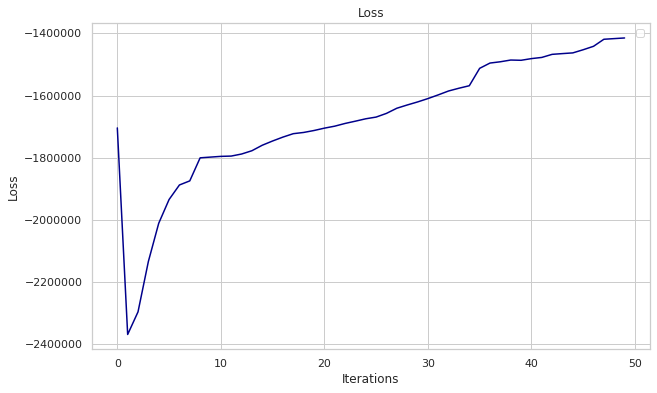

In [9]:
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(losses, color='darkblue')
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# VAE with convolution layers

In [0]:
class encoder_w_conv(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(encoder_w_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4, 4), 
                      padding=(15, 15), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), 
                      padding=(15, 15), stride=2),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, output_size)
        self.fc22 = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 784 * 128)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
      
class decoder_w_conv(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(decoder_w_conv, self).__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.ReLU(),
        ) 
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, padding=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, padding=1, stride=1),
            nn.Sigmoid(),
        )
    
    def forward(self, z):
        x = self.linear_layers(z)
        x = x.view(-1, 128, 28, 28)
        
        return self.conv(x)


In [0]:
class VAE_w_conv(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VAE_w_conv, self).__init__()
        self.encode = encoder_w_conv(input_size, hidden_size, output_size)
        self.decode = decoder_w_conv(input_size, hidden_size, output_size)    
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.encode.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
input_size, hidden_size, output_size = 784 * 128, 400, 20
lr = 1e-3
epochs = 50
model = VAE_w_conv(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

dloader it: 0
dloader it: 100
dloader it: 200
dloader it: 300
dloader it: 400
dloader it: 500
dloader it: 600
dloader it: 700
dloader it: 800
dloader it: 900
Epoch 0: -1487499.6625133262


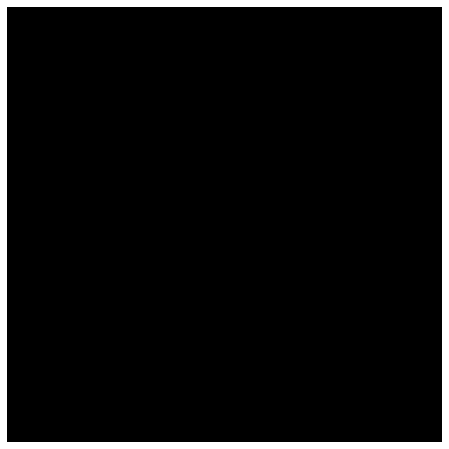

dloader it: 0
dloader it: 100
dloader it: 200
dloader it: 300
dloader it: 400
dloader it: 500
dloader it: 600
dloader it: 700
dloader it: 800
dloader it: 900
Epoch 1: -1444534.2896455224


<Figure size 432x288 with 0 Axes>

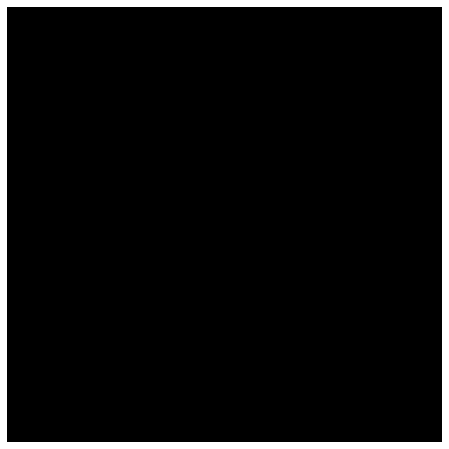

dloader it: 0
dloader it: 100
dloader it: 200
dloader it: 300
dloader it: 400
dloader it: 500
dloader it: 600
dloader it: 700
dloader it: 800
dloader it: 900
Epoch 2: -1415189.473280917


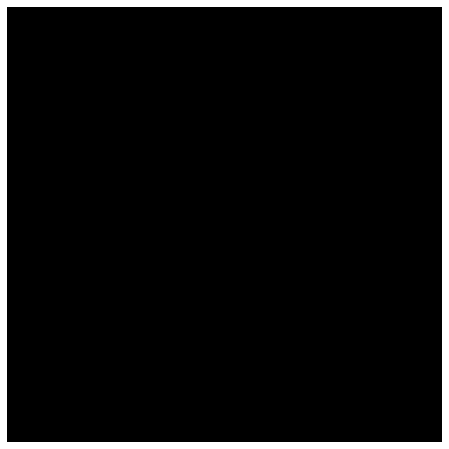

dloader it: 0
dloader it: 100
dloader it: 200
dloader it: 300
dloader it: 400
dloader it: 500
dloader it: 600
dloader it: 700
dloader it: 800
dloader it: 900
Epoch 3: -1408539.1497867804


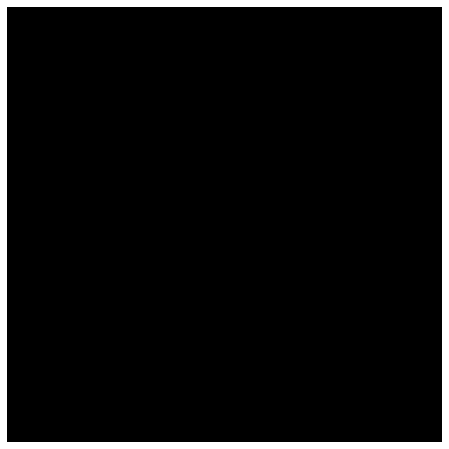

dloader it: 0
dloader it: 100


KeyboardInterrupt: ignored

In [109]:
model.train()
losses_conv = []
img_list = []
for i in range(epochs):
    loss_batches = []
    for j, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        image_gen, mu, logvar = model(data)      
        loss_bce = F.binary_cross_entropy(image_gen, data, reduction='sum')
        loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_bce + loss_kl
        loss.backward()
        loss_batches.append(loss.item())
        optimizer.step()
        if j % 100 == 0:
          print("dloader it: {}".format(j))        
    
    losses_conv.append(np.mean(loss_batches))
    print("Epoch {}: {}".format(i, losses_conv[-1]))
    
    with torch.no_grad():
        z = torch.randn(64, 20)
        z = model.decode(z).view(-1, 28, 28)
    img_list.append(vutils.make_grid(z.unsqueeze(1), 
                                      normalize=True, 
                                      nrow=8))
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.axis("off")
    plt.show()

    if i % 25 == 0:
        plt.savefig( "generated_gan_{}.png".format(i))